## Assingnement 4

### Objective: Obtain an accuracy of 92% using denent trained using SGD under 250 epochs

###  Result : 

  - Model-1 **982K params**
    - 4 Denseblocks with layers [8,6,20,12], growth rate= 12, , compression = 0.5, dropout = 0.2
    
    Achieved 90.15 (given in the log) *
    
    
    * by this time the connection got disconnected, the model achieved 90.65% which 
              
                                

Apporach:

Step 1. exploratory analysis

   - check if data distribution fine	
    
Step 2. Data preprocessng

   - Normalise the data before feeding the network
    
Step 3. Data Augmentation

   - this is complex network so we need more samples for the model to generalize well
   
   - we applied an intial augmentaion in **ImageDataGenerator()**
   
       - rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
       - width_shift_range=0.20,  # randomly shift images horizontally (fraction of total width)
       - height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
       - horizontal_flip=True,  # randomly flip images
		
  - the above augmentation looked insufficent and later we changed to the following settngs
  
    - rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
    - width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
    - height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
    - horizontal_flip=True,  # randomly flip images	

### Getting the right model and fine tuning the architecure

Step 5. Correcting the current code (**This was the most tricky part**)

   - Checked if given code for the model is correct.
   
   - referred the densent paper [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993) and checked online densent to verify whether my code is correct or not?
   
   - there was few corrections needed in the given code
   
   - Implemented Bottle neck layer, transitin  correctly in the given code

Step 6 - Getting the correct architecture

- aim was to use all the 1M parameter allowed

- I implemented two **Densent-BC** models

- Model-1 **982K params**
    - 4 Denseblocks with layers [8,6,20,12], growth rate= 12, , compression = 0.5, dropout = 0.2
    
- Model-2 **936K params**
    - 4 Denseblocks with layer  [14,14,14,14], growth rate= 12, compression = 0.5, dropout = 0.2
    
- 3 Denseblock layer 
    - it was tried  [16, 16, 16] but performance was not good so dorrpped

Step 6. Check if the chosen models will achive 92% target

-  training with **SGD()** is not going to be easy, so I tested the selected models using **Adam()** ,
       both the models I chose got more than 92 acccurcy
       
    - logs - Model-1 achieved 92% with Adam()
        - 
    - logs - Model-2 achieved 92% with Adam()
       - this seemed to converge slig
       
       
Step X. Training

   - in the densent paper they trained the network for 300 epohcs
      - varying the learning rate (**lr**) in the following way.
      - lr = 0.1 for 150 epochs (50% of epochs)
      - lr = 0.01 for next 75 epohcs ( 25%)
      - lr = 0.001 for last 75 epochs (25%)
      
  - I treid to follow a similiar distribution among 250 epocs.
       anothere thought was perormance improemnt from the last 25% epochs(lr = 0.001) is less in the paper
       so 150, 75, 25 to use the same split and train less using (lr = 0.001)
 
Step X. increace batch size instead of reducing leaning rate

   - DON’T DECAY THE LEARNING RATE, INCREASE THE BATCH SIZE (https://openreview.net/pdf?id=B1Yy1BxCZ)

   - I tried learning rate schdule manulal start and stop to reduce learning rate over time 
      but that does not seem to be worked.
      
   - This paper talks about a method of increasing batch size instead of reducint lr.
      basically they tell that reducing leaning rate by half is eqivalient to increacing batch size by 2.
      
   - I tried this technique to get the last push, seemed to be working but could not get pass the 92% mark
      
Step 9. Other appoaches tried 

   - tried kernel_initializer='he_normal' did not showed any differnce
      - log
      
   - tried cycling learning rate did not seem to help

   - Tried Sperable Convolution so I could increace the capcity, the model capacity was increased to 
       - Model-2 improved, became [16, 16, 18, 16] **957K parmas**
     
    
Step 9. Other appoaches tried 
   - Model-2 improved, is under training will update the results
        

In [9]:
# https://keras.io/
#!pip install -q keras
import keras

Using TensorFlow backend.


In [10]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam

In [11]:
import numpy as np
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight 
from sklearn import cross_validation

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
import matplotlib.pyplot as plt
import time, pickle
%matplotlib inline

In [13]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [14]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 50
#l = 40
#num_filter = 12
compression = 0.5
dropout_rate = 0.2

## Few Traing options

In [15]:
do_sub_sampling_of_input = False # for fast training use only 25 % of data
do_data_augmentation = True    # data augmentaion
do_data_append       = False   # data becomes 2X sized

In [16]:
# Load CIFAR10 Data

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]



In [17]:
nb_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

In [18]:
y_train[0], img_height, img_width, channel

(array([6], dtype=uint8), 32, 32, 3)

In [19]:
def draw_img(i, x_train, y_train, class_name):
    im = x_train[i]
    c = y_train[i]
    plt.imshow(im)
    plt.title("Class %d (%s)" % (int(c), class_name[int(c)]))
    plt.axis('on')

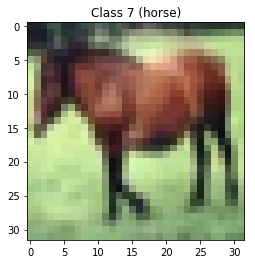

In [20]:
draw_img(7, x_train, y_train, class_name)

### Helper functions to dispaly and analyze data

These helper functions

plot_confusion_matrix(): helps us to plot the confusion matrix. 
It is taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html. 
The same page has some sample examples on how to use this function 
cm: Confusion matrix calcualted using confusion_matrix() from sklearn.metrics <br//> classes: a list of labels for the classes we are plotting
normalize=False: True means we will plot nomalized values 
title='Confusion matrix': set the tiltle of the plot 
cmap : leave it as it is 
Example Usage:plot_confusion_matrix(cm, classes=Facial_Expressions, normalize=True, title='Test Data - Using Simple Average Ensembling ')

plot_histogram(): helps to plot the histogram of a list 
lst_data: the list whose histogtam we want to plot , 
class_labels: a list of labels for the classes we are plotting 
ylabel='None': set the y label of the plot, x label is always frequency 
title='None': set the tiltle of the plot -lst_data, class_labels, ylabel='None', title='None'

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm) #to print in text if needed

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_histogram(lst_data, class_labels, ylabel='None', title='None'):
    data = pd.Series(lst_data)
    distribution = data.value_counts(sort=False)
    y_pos = np.arange(len(class_labels))
    
    plt.bar(y_pos, distribution, align='center', alpha=0.8)
    plt.xticks(y_pos, class_labels)
    plt.ylabel(ylabel)
    plt.title(title)

In [25]:
y_classes = ['airplane', 'automobile', 'bird','cat', 'deer','dog','frog','horse','ship','truck']

In [26]:
y_train.shape

(50000, 1)

## Visulalising the data, check for class distribution

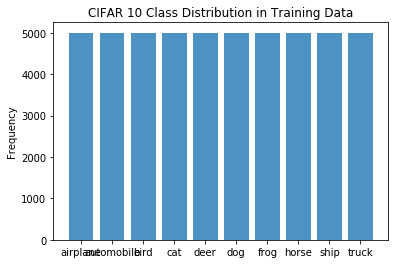

In [27]:
plot_histogram(list(y_train), y_classes, ylabel='Frequency',title='CIFAR 10 Class Distribution in Training Data')

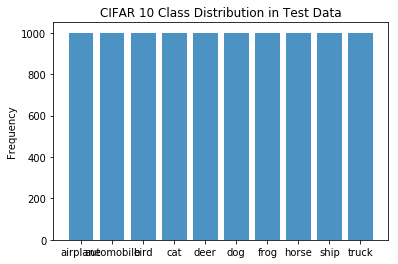

In [28]:
plot_histogram(list(y_test), y_classes, ylabel='Frequency',title='CIFAR 10 Class Distribution in Test Data')

In [29]:
# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

##  Normalising the input

In [30]:
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

mean  = np.mean(x_train, axis=(0, 1, 2), keepdims=True).astype('float32')
std   = np.std(x_train, axis=(0, 1, 2), keepdims=True).astype('float32')

mean1  = np.mean(x_test, axis=(0, 1, 2), keepdims=True).astype('float32')
std1   = np.std(x_test, axis=(0, 1, 2), keepdims=True).astype('float32')


print("Channel Mean : ", mean)
print("Channel Std : ", std)
print("Channel Mean1 : ", mean1)
print("Channel Std1 : ", std1)



x_train = (x_train - mean) / (std)
x_test  = (x_test - mean1) / (std1)

Channel Mean :  [[[[125.3069  122.95015 113.866  ]]]]
Channel Std :  [[[[62.99325  62.088604 66.70501 ]]]]
Channel Mean1 :  [[[[126.02428 123.70843 114.85442]]]]
Channel Std1 :  [[[[62.896416 61.937508 66.70607 ]]]]


### After normalisation input looks like this

In [31]:
x_train[0]

array([[[-1.0526032e+00, -9.8166406e-01, -7.6255137e-01],
        [-1.3065987e+00, -1.2393603e+00, -1.0323962e+00],
        [-1.1954757e+00, -1.2071482e+00, -1.0623789e+00],
        ...,
        [ 5.1899368e-01,  1.4575703e-01, -8.7939382e-02],
        [ 4.2374539e-01,  3.3014923e-02, -1.7788765e-01],
        [ 3.6024651e-01,  1.6908908e-02, -1.6289628e-01]],

       [[-1.7352160e+00, -1.6581167e+00, -1.4071807e+00],
        [-1.9892114e+00, -1.9802370e+00, -1.7070082e+00],
        [-1.7034665e+00, -1.8513888e+00, -1.7070082e+00],
        ...,
        [-3.6621384e-02, -5.6290764e-01, -8.8248241e-01],
        [-1.0012025e-01, -6.4343774e-01, -9.5743930e-01],
        [-5.2496098e-02, -5.7901365e-01, -8.5249966e-01]],

       [[-1.5923436e+00, -1.5936927e+00, -1.3921893e+00],
        [-1.7352160e+00, -1.8674948e+00, -1.7070082e+00],
        [-1.2113504e+00, -1.5453745e+00, -1.5870771e+00],
        ...,
        [-1.1599497e-01, -6.2733167e-01, -9.5743930e-01],
        [-8.4245533e-02, -6.2

In [32]:
print(x_train.shape, x_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [33]:
print(y_train.shape, y_test.shape)

(50000, 10) (10000, 10)


In [34]:
if do_sub_sampling_of_input:
    x_, x_train, x_, y_train    = cross_validation.train_test_split(x_train, y_train, test_size=0.25, random_state=0)
    x_, x_test,  y_, y_test    = cross_validation.train_test_split(x_test, y_test, test_size=0.25, random_state=0)
    print("After SubSampling")
    print(x_train.shape, x_test.shape)
    print(y_train.shape, y_test.shape)

In [35]:
import numpy as np

if do_data_append :
    print("Doing Data Appending")
    x_train = np.append(x_train, x_train,axis=0)
    y_train = np.append(y_train, y_train,axis=0)
#print(np.append(x_train, x_train,axis=0).shape)
#print(np.append(y_train, y_train,axis=0).shape)


In [36]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 10) (10000, 10)


# Data Augmentation

In [37]:
keras.utils.Sequence
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='nearest')

In [38]:
from keras.layers import SeparableConv2D

# Construction densenet -BC

In [39]:
# Dense Block
def add_denseblock(input, growth_rate, dropout_rate = 0.2, l = 0):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)

        Conv2D_1_1 = Conv2D(int(growth_rate*4), (1,1), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_1_1 = Dropout(dropout_rate)(Conv2D_1_1)
        BatchNorm_1_1 = BatchNormalization()(Conv2D_1_1)
        relu_1_1 = Activation('relu')(BatchNorm_1_1)
        
        Conv2D_3_3 = Conv2D(int(growth_rate), (3,3), use_bias=False ,padding='same')(relu_1_1)
        #Conv2D_3_3 = SeparableConv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu_1_1) # later tried this
        if dropout_rate>0:
            Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [40]:
def add_transition(input, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    num_channels = int(input.shape[-1]) #assuming it is tensor
    Conv2D_BottleNeck = Conv2D(int(num_channels*compression), (1,1), use_bias=False ,padding='same')(relu)
    

    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [41]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    #flat = Dropout(0.25)(flat) # tried this, did not help
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [42]:
num_filter = growth_rate = 12
dropout_rate = 0.2
compression = 0.5
dense_l= [8, 16, 20, 12]

input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(2*num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, growth_rate, dropout_rate, dense_l[0])
First_Transition = add_transition(First_Block, dropout_rate)

Second_Block = add_denseblock(First_Transition, growth_rate, dropout_rate, dense_l[1])
Second_Transition = add_transition(Second_Block, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate, dense_l[2])
Third_Transition = add_transition(Third_Block, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  growth_rate, dropout_rate, dense_l[3])
output = output_layer(Last_Block)



## Printing and Verifying the Densenet-BC configuration

In [43]:
print(input.shape)
print(First_Conv2D.shape)
print(First_Block.shape, First_Block.shape[-1])
print(First_Transition.shape)

print(Second_Block.shape)
print(Second_Transition.shape)

print(Third_Block.shape)
print(Third_Transition.shape)

print(Last_Block.shape)

(?, 32, 32, 3)
(?, 32, 32, 24)
(?, 32, 32, 120) 120
(?, 16, 16, 60)
(?, 16, 16, 252)
(?, 8, 8, 126)
(?, 8, 8, 366)
(?, 4, 4, 183)
(?, 4, 4, 327)


In [44]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 24)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

batch_normalization_95 (BatchNo (None, 4, 4, 48)     192         dropout_94[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 4, 4, 48)     0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 4, 4, 12)     5184        activation_95[0][0]              
__________________________________________________________________________________________________
dropout_95 (Dropout)            (None, 4, 4, 12)     0           conv2d_96[0][0]                  
__________________________________________________________________________________________________
concatenate_46 (Concatenate)    (None, 4, 4, 207)    0           concatenate_45[0][0]             
                                                                 dropout_95[0][0]                 
__________

# Settinng the optimizer

In [47]:
learning_rate = 0.1
epochs = 90
decay = learning_rate/epochs
decay = 0.0001

sgd = keras.optimizers.SGD(lr=learning_rate, decay=decay, momentum=0.9, nesterov=True)

In [48]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer= sgd,
              metrics=['accuracy'])

## Functions to adjust learning rate

In [56]:
from keras.callbacks import LearningRateScheduler
import numpy
import math

In [49]:
# cycling learning rate was enabled before
#batch_size = 64
#clr_triangular = CyclicLR(mode='triangular', base_lr = 0.1, max_lr = 0.2, step_size = (len(x_train)* 2 * 4)/batch_size)

In [50]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 30.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [51]:
# learning rate schedule
def step_decay1(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epoch_drop_01 = 40
    epoch_drop_02 = epoch_drop_01 + 40
    epoch_drop_03 = epoch_drop_02 + 40
    
    if (epoch < epoch_drop_01):
        lrate = initial_lrate
    elif (epoch < epoch_drop_02):
        lrate = initial_lrate * drop
    else:
        lrate = initial_lrate * drop * drop

    return lrate

In [52]:
def on_epoch_end(self, epoch, logs=None):
    print("epoch: ", epoch,"learning rate for", K.eval(self.model.optimizer.lr))

In [57]:
lrate = LearningRateScheduler(step_decay1)

In [58]:
from keras.callbacks import ReduceLROnPlateau

reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.001)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience= 4, min_delta=0.003, verbose=1, cooldown=0, min_lr=0.001)

In [59]:
from keras.callbacks import ModelCheckpoint

## Model Saving

In [60]:
#from google.colab import files
#filepath = file_prefix + r".best.hdf5"
filepath = "DNST_CIFAR10_Conv_09_09_final_tr2-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)


In [61]:
# Save the trained weights in to .h5 format
#model.save_weights("densenet_tr_03-{epoch:02d}-{val_acc:.2f}.hdf5")
#print("Saved model to disk")

In [62]:
#from google.colab import files

#files.download('DNST_model.h5')

In [63]:
from keras import backend as K
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau

from keras.callbacks import LearningRateScheduler

In [64]:
class AdamTracker_0(Callback):
    def on_epoch_begin(self, epoch, logs={}):
        optimizer = self.model.optimizer
        #lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        #print('\nLR: {:.6f}\n'.format(lr))
        print("start , epoch = ", epoch,", lr = ", K.eval(optimizer.lr),", decay = ",K.eval(optimizer.decay),)

In [65]:
class AdamTracker_1(Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        #lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        #print('\nLR: {:.6f}\n'.format(lr))
        print("end, epoch = ", epoch,", lr = ", K.eval(optimizer.lr),", decay = ",K.eval(optimizer.decay),)

In [66]:
adam_lr_tracker_1 = AdamTracker_1()
adam_lr_tracker_0 = AdamTracker_0()

In [67]:
class SGDLearningRateTracker(Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        #lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        #print('\nLR: {:.6f}\n'.format(lr))
        print("epoch = ", epoch,", lr = ", K.eval(optimizer.lr), ", momentum = ",K.eval(optimizer.momentum),
              ", decay = ",K.eval(optimizer.decay), ", Nestrov = ",optimizer.nesterov)

## Setting call backs

In [68]:
sgd_lr_tracker = SGDLearningRateTracker()

In [69]:
callbacks_list = [checkpoint, reduce_on_plateau]

In [70]:
callbacks_list = [adam_lr_tracker_0, adam_lr_tracker_1]

In [71]:
#callbacks_list = [checkpoint, adam_lr_tracker_0, adam_lr_tracker_1, clr_triangular]

In [72]:
callbacks_list = [checkpoint, sgd_lr_tracker]

In [62]:
len(x_train)

50000

## Train the model with the datagen, augmentation

In [84]:
batch_size = 64
epochs = 80

In [85]:
load_model_from_back = False

if load_model_from_back:
    model = load_model('--------------')
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [86]:
import keras.backend as K
k.set_value(model.optimizer.lr, 0.1)
k.set_value(model.optimizer.momentum, 0.9)

print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)

0.1
0.9
1e-04
True


## Let's train the model for 120 epochs first

In [87]:
batch_size = 128
epochs = 120

if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train)* 1.0)/batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)    

Epoch 1/120
391/390 [==============================] - 111s 283ms/step - loss: 2.1374 - acc: 0.2882 - val_loss: 1.7219 - val_acc: 0.3712

Epoch 00001: val_acc improved from 0.11190 to 0.37120, saving model to DNST_CIFAR10_Conv_09_09_final_tr2-01-0.3712.hdf5
epoch =  0 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 2/120
391/390 [==============================] - 76s 195ms/step - loss: 1.6473 - acc: 0.3983 - val_loss: 1.5223 - val_acc: 0.4480

Epoch 00002: val_acc improved from 0.37120 to 0.44800, saving model to DNST_CIFAR10_Conv_09_09_final_tr2-02-0.4480.hdf5
epoch =  1 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 3/120
391/390 [==============================] - 77s 196ms/step - loss: 1.4703 - acc: 0.4662 - val_loss: 1.3615 - val_acc: 0.5148

Epoch 00003: val_acc improved from 0.44800 to 0.51480, saving model to DNST_CIFAR10_Conv_09_09_final_tr2-03-0.5148.hdf5
epoch =  2 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True


391/390 [==============================] - 77s 197ms/step - loss: 0.4670 - acc: 0.8364 - val_loss: 0.6365 - val_acc: 0.8114

Epoch 00028: val_acc did not improve from 0.81570
epoch =  27 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 29/120
391/390 [==============================] - 78s 199ms/step - loss: 0.4545 - acc: 0.8403 - val_loss: 0.6620 - val_acc: 0.8066

Epoch 00029: val_acc did not improve from 0.81570
epoch =  28 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 30/120
391/390 [==============================] - 77s 198ms/step - loss: 0.4431 - acc: 0.8430 - val_loss: 0.5758 - val_acc: 0.8264

Epoch 00030: val_acc improved from 0.81570 to 0.82640, saving model to DNST_CIFAR10_Conv_09_09_final_tr2-30-0.8264.hdf5
epoch =  29 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 31/120
391/390 [==============================] - 77s 196ms/step - loss: 0.4358 - acc: 0.8453 - val_loss: 0.6433 - val_acc: 0.8066

Epoch 0003


Epoch 00057: val_acc did not improve from 0.86690
epoch =  56 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 58/120
391/390 [==============================] - 77s 196ms/step - loss: 0.2894 - acc: 0.8969 - val_loss: 0.4678 - val_acc: 0.8701

Epoch 00058: val_acc improved from 0.86690 to 0.87010, saving model to DNST_CIFAR10_Conv_09_09_final_tr2-58-0.8701.hdf5
epoch =  57 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 59/120
391/390 [==============================] - 77s 196ms/step - loss: 0.2884 - acc: 0.8975 - val_loss: 0.5209 - val_acc: 0.8623

Epoch 00059: val_acc did not improve from 0.87010
epoch =  58 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 60/120
391/390 [==============================] - 77s 197ms/step - loss: 0.2832 - acc: 0.9010 - val_loss: 0.5154 - val_acc: 0.8598

Epoch 00060: val_acc did not improve from 0.87010
epoch =  59 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 6

391/390 [==============================] - 77s 196ms/step - loss: 0.2230 - acc: 0.9195 - val_loss: 0.4940 - val_acc: 0.8748

Epoch 00087: val_acc did not improve from 0.88360
epoch =  86 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 88/120
391/390 [==============================] - 77s 197ms/step - loss: 0.2136 - acc: 0.9246 - val_loss: 0.5173 - val_acc: 0.8727

Epoch 00088: val_acc did not improve from 0.88360
epoch =  87 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 89/120
391/390 [==============================] - 77s 198ms/step - loss: 0.2161 - acc: 0.9228 - val_loss: 0.5355 - val_acc: 0.8709

Epoch 00089: val_acc did not improve from 0.88360
epoch =  88 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 90/120
391/390 [==============================] - 77s 196ms/step - loss: 0.2177 - acc: 0.9209 - val_loss: 0.4809 - val_acc: 0.8806

Epoch 00090: val_acc did not improve from 0.88360
epoch =  89 , lr =  0.1 , mome

391/390 [==============================] - 79s 201ms/step - loss: 0.1753 - acc: 0.9382 - val_loss: 0.4770 - val_acc: 0.8922

Epoch 00117: val_acc improved from 0.89160 to 0.89220, saving model to DNST_CIFAR10_Conv_09_09_final_tr2-117-0.8922.hdf5
epoch =  116 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 118/120
391/390 [==============================] - 78s 200ms/step - loss: 0.1733 - acc: 0.9375 - val_loss: 0.4928 - val_acc: 0.8852

Epoch 00118: val_acc did not improve from 0.89220
epoch =  117 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 119/120
391/390 [==============================] - 78s 199ms/step - loss: 0.1737 - acc: 0.9381 - val_loss: 0.5319 - val_acc: 0.8757

Epoch 00119: val_acc did not improve from 0.89220
epoch =  118 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 120/120
391/390 [==============================] - 77s 198ms/step - loss: 0.1735 - acc: 0.9380 - val_loss: 0.5974 - val_acc: 0.8720

Epo

In [113]:
#num_filter = 12
num_filter = 12
growth_rate = 12
dropout_rate = 0.2
#compression = 0.751
compression = 0.5
l = 16
dense_l= [8, 16, 20, 12]

input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(2*num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, growth_rate, dropout_rate, dense_l[0])
First_Transition = add_transition(First_Block, dropout_rate)

Second_Block = add_denseblock(First_Transition, growth_rate, dropout_rate, dense_l[1])
Second_Transition = add_transition(Second_Block, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate, dense_l[2])
Third_Transition = add_transition(Third_Block, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  growth_rate, dropout_rate, dense_l[3])
output = output_layer(Last_Block)


In [114]:
model = Model(inputs=[input], outputs=[output])
#model.summary()

In [115]:
learning_rate = 0.1
epochs = 90
decay = learning_rate/epochs
decay = 0.0001

sgd = keras.optimizers.SGD(lr=learning_rate, decay=decay, momentum=0.9, nesterov=True)

In [116]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer= sgd,
              metrics=['accuracy'])

In [117]:
load_model_from_back = True

if load_model_from_back:
    model.load_weights('DNST_CIFAR10_Conv_09_09_final_tr2-63-0.8762.hdf5')
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    score = model.evaluate(x_train, y_train, verbose=1)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])

10000/10000 [==============================] - 18s 2ms/step
Test loss: 0.4431272743701935
Test accuracy: 0.8762
50000/50000 [==============================] - 35s 691us/step
Train loss: 0.22539761049449444
Train accuracy: 0.92494


In [118]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='nearest')

In [119]:
# import keras.backend as K
k.set_value(model.optimizer.lr, 0.1)

print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)

0.1
0.9
1e-04
True


# 13:56 30 october, more agumentaion, 2x

In [ ]:
batch_size = 256
epochs = 175

if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train)* 2.0)/batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)

Epoch 1/175
391/390 [==============================] - 137s 352ms/step - loss: 0.3197 - acc: 0.8874 - val_loss: 0.5486 - val_acc: 0.8560

Epoch 00001: val_acc did not improve from 0.89750
epoch =  0 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 2/175
391/390 [==============================] - 98s 251ms/step - loss: 0.3092 - acc: 0.8902 - val_loss: 0.5944 - val_acc: 0.8460

Epoch 00002: val_acc did not improve from 0.89750
epoch =  1 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 3/175
391/390 [==============================] - 99s 252ms/step - loss: 0.2999 - acc: 0.8939 - val_loss: 0.4826 - val_acc: 0.8684

Epoch 00003: val_acc did not improve from 0.89750
epoch =  2 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 4/175
391/390 [==============================] - 99s 252ms/step - loss: 0.2916 - acc: 0.8967 - val_loss: 0.6128 - val_acc: 0.8455

Epoch 00004: val_acc did not improve from 0.89750
epoch =  3 , lr =  0.1 

391/390 [==============================] - 98s 250ms/step - loss: 0.1652 - acc: 0.9412 - val_loss: 0.5018 - val_acc: 0.8896

Epoch 00032: val_acc did not improve from 0.89750
epoch =  31 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 33/175
391/390 [==============================] - 98s 251ms/step - loss: 0.1641 - acc: 0.9411 - val_loss: 0.5301 - val_acc: 0.8902

Epoch 00033: val_acc did not improve from 0.89750
epoch =  32 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 34/175
391/390 [==============================] - 98s 250ms/step - loss: 0.1631 - acc: 0.9410 - val_loss: 0.5457 - val_acc: 0.8838

Epoch 00034: val_acc did not improve from 0.89750
epoch =  33 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 35/175
391/390 [==============================] - 98s 250ms/step - loss: 0.1594 - acc: 0.9431 - val_loss: 0.4999 - val_acc: 0.8890

Epoch 00035: val_acc did not improve from 0.89750
epoch =  34 , lr =  0.1 , mome

391/390 [==============================] - 98s 251ms/step - loss: 0.1184 - acc: 0.9573 - val_loss: 0.5770 - val_acc: 0.8931

Epoch 00063: val_acc did not improve from 0.89930
epoch =  62 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 64/175
391/390 [==============================] - 98s 250ms/step - loss: 0.1192 - acc: 0.9575 - val_loss: 0.5461 - val_acc: 0.8975

Epoch 00064: val_acc did not improve from 0.89930
epoch =  63 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 65/175
391/390 [==============================] - 98s 250ms/step - loss: 0.1132 - acc: 0.9589 - val_loss: 0.5862 - val_acc: 0.8909

Epoch 00065: val_acc did not improve from 0.89930
epoch =  64 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 66/175
391/390 [==============================] - 98s 250ms/step - loss: 0.1142 - acc: 0.9591 - val_loss: 0.5858 - val_acc: 0.8907

Epoch 00066: val_acc did not improve from 0.89930
epoch =  65 , lr =  0.1 , mome

# 19:29 30 october, more agumentaion, 2x

In [121]:
load_model_from_back = True

if load_model_from_back:
    model.load_weights('DNST_CIFAR10_Conv_09_09_final_tr2-63-0.8762.hdf5')
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    score = model.evaluate(x_train, y_train, verbose=1)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])

10000/10000 [==============================] - 7s 654us/step
Test loss: 0.4431272743701935
Test accuracy: 0.8762
50000/50000 [==============================] - 32s 649us/step
Train loss: 0.22539761049449444
Train accuracy: 0.92494


In [122]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='nearest')

In [123]:
# import keras.backend as K
k.set_value(model.optimizer.lr, 0.1)

print(K.eval(model.optimizer.lr))
print(K.eval(model.optimizer.momentum))
print(K.eval(model.optimizer.decay))
print(model.optimizer.nesterov)

0.1
0.9
1e-04
True


In [ ]:
batch_size = 256
epochs = 250- 63

if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train)* 3.0)/batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)

Epoch 1/187
586/585 [==============================] - 142s 243ms/step - loss: 0.4413 - acc: 0.8467 - val_loss: 0.4100 - val_acc: 0.8796

Epoch 00001: val_acc did not improve from 0.90610
epoch =  0 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 2/187
586/585 [==============================] - 141s 241ms/step - loss: 0.4101 - acc: 0.8570 - val_loss: 0.4392 - val_acc: 0.8717

Epoch 00002: val_acc did not improve from 0.90610
epoch =  1 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 3/187
586/585 [==============================] - 141s 240ms/step - loss: 0.3970 - acc: 0.8610 - val_loss: 0.4301 - val_acc: 0.8778

Epoch 00003: val_acc did not improve from 0.90610
epoch =  2 , lr =  0.1 , momentum =  0.9 , decay =  1e-04 , Nestrov =  True
Epoch 4/187
586/585 [==============================] - 141s 241ms/step - loss: 0.3864 - acc: 0.8645 - val_loss: 0.4272 - val_acc: 0.8777

Epoch 00004: val_acc did not improve from 0.90610
epoch =  3 , lr =  0